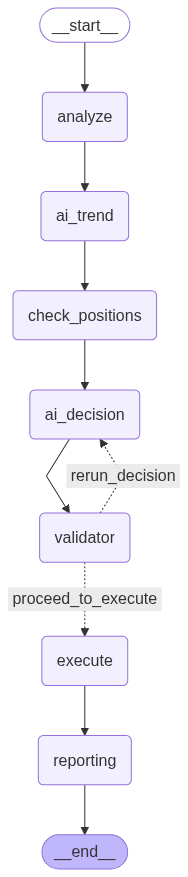

In [1]:
# /trading_bot/main_trading_notebook.ipynb

# === IMPORTS AND SETUP ===
import asyncio
import json
from datetime import datetime
from typing import TypedDict, Dict, List

from langgraph.graph import StateGraph, END
from IPython.display import Image, display

from config import *
from utils import *
from market_data import *
from agent import *
from reporting import *
from diagnostics import *

import nest_asyncio
nest_asyncio.apply()

# Get news summary for your portfolio
from news_working import get_news_summary_for_trading


# === AGENT STATE DEFINITION ===
class PortfolioState(TypedDict):
    """Defines the state that flows through the agent graph."""
    timestamp: str
    cycle_number: int
    portfolio_stocks: List[str]
    stock_data: Dict[str, Dict]
    stock_prices: Dict[str, float]
    stock_smas: Dict[str, float]
    ai_trend_analysis: Dict[str, Dict]
    positions: Dict[str, int]
    stock_pnls: Dict[str, float]
    purchase_prices: Dict[str, float]
    total_portfolio_value: float
    total_unrealized_pnl: float
    total_trades: int
    total_fees_paid: float
    cash_available: float
    ai_recommendations: Dict[str, Dict]
    executed_trades: List[Dict]
    portfolio_allocation: Dict[str, float]
    session_start_time: str
    session_id: str
    cycle_history: List[Dict]
    validation_attempts: int
    validation_history: List[Dict]
    final_decision_logic: str
    validation_feedback: str
    # --- NEW FIELD FOR STRATEGY ---
    aggressive_mode: bool


# === AGENT GRAPH NODES ===
async def analyze_portfolio_node(state: PortfolioState) -> PortfolioState:
    """Node to fetch market data and update the state."""
    print(f"\n--- Cycle {state['cycle_number']}: Analyzing Market ---")
    stock_data = await get_stock_data_batch(state['portfolio_stocks'])
    
    state['timestamp'] = datetime.now().isoformat()
    state['stock_data'] = stock_data
    state['stock_prices'] = {s: d.get('current_price', 0) for s, d in stock_data.items()}
    state['stock_smas'] = {s: d.get('sma_20', 0) for s, d in stock_data.items()}
    
    valid_count = len([s for s, d in stock_data.items() if d.get('valid')])
    print(f"✅ Analysis complete. Fetched valid data for {valid_count}/{len(state['portfolio_stocks'])} stocks.")
    
    return state

async def parallel_analysis_node(state: PortfolioState) -> PortfolioState:
    """Run AI trend analysis and news analysis in parallel."""
    print("🤖 Running parallel AI trend analysis and news analysis...")
    
    # Create tasks that can run in parallel
    async def ai_analysis():
        ai_trend_analysis = {}
        for symbol in state['portfolio_stocks']:
            analysis = await get_ai_trend_analysis(state['stock_data'], symbol)
            ai_trend_analysis[symbol] = analysis
            await asyncio.sleep(0.2)  # Rate limiting
        return ai_trend_analysis
    
    async def news_analysis():
        news_summary = await get_news_summary_for_trading()
        return news_summary
    
    # Run both in parallel
    ai_results, news_results = await asyncio.gather(
        ai_analysis(),
        news_analysis()
    )
    
    state['ai_trend_analysis'] = ai_results
    state['news_sentiment'] = news_results
    
    # Log news insights
    for symbol, news in news_results.items():
        if news['has_news']:
            print(f"📰 {symbol}: {news['sentiment_emoji']} {news['sentiment_label']}")
    
    print("✅ Parallel analysis complete.")
    return state


async def check_positions_node(state: PortfolioState) -> PortfolioState:
    """Node to check current portfolio positions and value."""
    print("📊 Checking portfolio positions and value...")
    positions, pnls = await get_all_positions()
    portfolio_value, cash = await get_portfolio_summary()
    
    state['positions'] = positions
    state['stock_pnls'] = pnls
    state['total_portfolio_value'] = portfolio_value
    state['total_unrealized_pnl'] = sum(pnls.values())
    state['cash_available'] = cash
    
    allocations = {}
    for symbol in state['portfolio_stocks']:
        if portfolio_value > 0:
            stock_value = positions.get(symbol, 0) * state['stock_prices'].get(symbol, 0)
            allocations[symbol] = (stock_value / portfolio_value) * 100
        else:
            allocations[symbol] = 0.0
    state['portfolio_allocation'] = allocations
    
    print(f"✅ Positions checked. Value: ${portfolio_value:,.2f}, P&L: ${state['total_unrealized_pnl']:+.2f}")
    return state

async def ai_decision_node(state: PortfolioState) -> PortfolioState:
    """Node for the AI to make trading decisions."""
    strategy_mode = "Aggressive" if state.get('aggressive_mode') else "Balanced"
    
    if state.get("validation_feedback"):
        print(f"🧠 Re-generating AI recommendations ({strategy_mode} Mode) with validation feedback...")
    else:
        print(f"🧠 Generating initial AI recommendations ({strategy_mode} Mode)...")
    
    if check_emergency_stop_loss(state):
        print("🚨 EMERGENCY STOP-LOSS: Recommending SELL on all positions!")
        recs = {s: {'action': 'SELL', 'priority': 'HIGH', 'reasoning': 'Portfolio stop-loss'} for s, p in state['positions'].items() if p > 0}
    else:
        recs = await get_ai_portfolio_recommendations(state)

    stop_loss_actions = check_stop_loss_conditions(state)
    for symbol, action in stop_loss_actions.items():
        recs[symbol] = {'action': action, 'priority': 'HIGH', 'reasoning': f'Triggered {action} based on price change'}

    state['ai_recommendations'] = recs
    print("✅ AI recommendations generated.")
    return state

async def validate_decisions_node(state: PortfolioState) -> PortfolioState:
    """Node that runs the validation logic and stores feedback."""
    print("🕵️  Validating AI Decisions...")
    
    if state.get('validation_attempts', 0) >= 2:
        print("⚠️ Max validation attempts reached. Proceeding with last decision.")
        state['final_decision_logic'] = "Forced proceed after max validation retries."
        state['validation_history'].append({'decision': 'proceed', 'reason': 'Max retries.'})
        state['validation_feedback'] = ""
        return state

    validation_result = validate_ai_decisions(state)
    
    history = state.get('validation_history', [])
    history.append({
        'timestamp': datetime.now().isoformat(),
        'attempt': state.get('validation_attempts', 0) + 1,
        **validation_result
    })
    state['validation_history'] = history
    state['validation_attempts'] = state.get('validation_attempts', 0) + 1
    
    if validation_result['decision'] == 'proceed':
        print(f"✅ Validation Passed: {validation_result['reason']}")
        state['final_decision_logic'] = validation_result['reason']
        state['validation_feedback'] = ""
    else:
        print(f"❌ Validation Failed: {validation_result['reason']}. Rerunning...")
        state['final_decision_logic'] = f"Rerun after attempt {state['validation_attempts']}"
        state['validation_feedback'] = validation_result['reason']

    return state

# async def execute_trades_node(state: PortfolioState) -> PortfolioState:
#     """Node to execute trades based on final recommendations."""
#     print("⚡ Executing trades...")
#     recommendations = state.get('ai_recommendations', {})
#     executed_trades = []
    
#     priority_order = {'HIGH': 3, 'MEDIUM': 2, 'LOW': 1}
#     sorted_recs = sorted(recommendations.items(), key=lambda x: priority_order.get(x[1].get('priority', 'LOW'), 0), reverse=True)
    
#     for symbol, rec in sorted_recs:
#         action = rec.get('action')
#         if action in ['BUY', 'SELL']:
#             print(f"   - Executing {action} for {symbol}")
#             executed_trades.append({'symbol': symbol, 'action': action, 'quantity': TRADE_SIZE, 'price': state['stock_prices'].get(symbol)})

#     state['executed_trades'] = executed_trades
#     state['total_trades'] += len(executed_trades)
#     print(f"✅ Execution complete. {len(executed_trades)} trades attempted.")
#     return state

async def reporting_node(state: PortfolioState) -> PortfolioState:
    """Node to generate and save all reports."""
    print("📝 Generating reports...")
    
    cycle_data = {k: v for k, v in state.items() if k != 'cycle_history'}
    state['cycle_history'].append(cycle_data)

    # Before generating your report, add news:
    state = await add_news_to_current_cycle(state)
    
    generate_html_report(state)
    generate_json_report(state)
    generate_csv_report(state)
    
    print("✅ Reports generated and saved.")
    return state


# Add the enhanced place_smart_order function with detailed logging
async def place_smart_order(symbol: str, action: str, quantity: int):
    """Place order with enhanced error handling and detailed logging"""
    order_start_time = datetime.now()
    print(f"\n🔄 [{order_start_time.strftime('%H:%M:%S')}] INITIATING ORDER: {action} {quantity} {symbol}")
    
    try:
        # Step 1: Establish connection
        print(f"   📡 Establishing IB connection...")
        ib = await ensure_connection()
        if not ib:
            error_msg = f"❌ Connection failed for {symbol}"
            print(f"   {error_msg}")
            return {"success": False, "error": error_msg, "symbol": symbol}
        print(f"   ✅ IB connection established")
        
        # Step 2: Create and qualify contract
        print(f"   📋 Creating contract for {symbol}...")
        contract = Stock(symbol, 'SMART', 'USD')
        print(f"   🔍 Qualifying contract...")
        
        qualified_contracts = await ib.qualifyContractsAsync(contract)
        if not qualified_contracts:
            error_msg = f"❌ Could not qualify contract for {symbol}"
            print(f"   {error_msg}")
            return {"success": False, "error": error_msg, "symbol": symbol}
        
        qualified_contract = qualified_contracts[0]
        print(f"   ✅ Contract qualified: {qualified_contract.symbol} @ {qualified_contract.exchange}")
        
        # Step 3: Create order
        print(f"   📝 Creating {action} order for {quantity} shares...")
        order = MarketOrder(action, quantity)
        order.account = ""  # Will use default account
        print(f"   📊 Order details: Type={order.orderType}, Action={order.action}, Quantity={order.totalQuantity}")
        
        # Step 4: Place order
        print(f"   🚀 Placing order...")
        trade = ib.placeOrder(qualified_contract, order)
        
        # Step 5: Wait briefly for initial order status
        await asyncio.sleep(1)
        
        # Step 6: Get order status and details
        order_id = trade.order.orderId if trade.order else "N/A"
        order_status = trade.orderStatus.status if trade.orderStatus else "Unknown"
        filled_qty = trade.orderStatus.filled if trade.orderStatus else 0
        remaining_qty = trade.orderStatus.remaining if trade.orderStatus else quantity
        avg_fill_price = trade.orderStatus.avgFillPrice if trade.orderStatus else 0
        
        order_end_time = datetime.now()
        duration = (order_end_time - order_start_time).total_seconds()
        
        print(f"   📈 ORDER SUBMITTED SUCCESSFULLY!")
        print(f"   🆔 Order ID: {order_id}")
        print(f"   📊 Status: {order_status}")
        print(f"   📦 Filled: {filled_qty} / Remaining: {remaining_qty}")
        if avg_fill_price > 0:
            print(f"   💰 Average Fill Price: ${avg_fill_price:.2f}")
        print(f"   ⏱️  Execution Time: {duration:.2f} seconds")
        
        # Return detailed response
        return {
            "success": True,
            "symbol": symbol,
            "action": action,
            "quantity": quantity,
            "order_id": order_id,
            "status": order_status,
            "filled": filled_qty,
            "remaining": remaining_qty,
            "avg_fill_price": avg_fill_price,
            "execution_time": duration,
            "trade_object": trade
        }
        
    except Exception as e:
        order_end_time = datetime.now()
        duration = (order_end_time - order_start_time).total_seconds()
        error_msg = f"Order execution failed for {symbol}: {str(e)}"
        print(f"   ❌ ORDER FAILED!")
        print(f"   🚫 Error: {str(e)}")
        print(f"   ⏱️  Time to failure: {duration:.2f} seconds")
        
        return {
            "success": False,
            "symbol": symbol,
            "action": action,
            "quantity": quantity,
            "error": str(e),
            "execution_time": duration
        }

# REPLACE your existing execute_trades_node with this ENHANCED version with detailed logging
async def execute_trades_node(state: PortfolioState) -> PortfolioState:
    """Execute AI-recommended trades across portfolio - ENHANCED with comprehensive logging"""
    execution_start_time = datetime.now()
    print("\n" + "="*80)
    print("⚡ STARTING TRADE EXECUTION PHASE")
    print("="*80)
    
    recommendations = state['ai_recommendations']
    positions = state['positions']
    total_shares = sum(positions.values())
    executed_trades = []
    failed_trades = []

    # Enhanced cash availability check
    available_cash = state['cash_available']
    initial_cash = available_cash
    print(f"💵 INITIAL CASH AVAILABLE: ${available_cash:,.2f}")
    print(f"📊 CURRENT TOTAL SHARES HELD: {total_shares}")
    print(f"🎯 TRADE SIZE PER ORDER: {TRADE_SIZE}")
    print(f"🛡️  MINIMUM CASH RESERVE: ${MIN_CASH_RESERVE:,.2f}")
    
    if not recommendations:
        print("⚠️  NO AI RECOMMENDATIONS FOUND - SKIPPING EXECUTION")
        state['executed_trades'] = []
        return state
    
    print(f"\n📋 PROCESSING {len(recommendations)} AI RECOMMENDATIONS:")
    for symbol, rec in recommendations.items():
        action = rec.get('action', 'HOLD')
        priority = rec.get('priority', 'LOW')
        reasoning = rec.get('reasoning', 'No reasoning provided')
        print(f"   🔸 {symbol}: {action} ({priority} priority) - {reasoning}")

    # Sort by priority (HIGH -> MEDIUM -> LOW)
    priority_order = {'HIGH': 3, 'MEDIUM': 2, 'LOW': 1}
    sorted_recommendations = sorted(
        recommendations.items(),
        key=lambda x: priority_order.get(x[1].get('priority', 'LOW'), 0),
        reverse=True
    )
    
    print(f"\n🔄 EXECUTING TRADES IN PRIORITY ORDER:")
    trades_executed = 0
    total_estimated_value = 0

    for idx, (symbol, rec) in enumerate(sorted_recommendations, 1):
        print(f"\n{'='*60}")
        print(f"📈 PROCESSING TRADE {idx}/{len(sorted_recommendations)}: {symbol}")
        print(f"{'='*60}")
        
        action = rec.get('action', 'HOLD')
        priority = rec.get('priority', 'LOW')
        current_position = positions.get(symbol, 0)
        current_price = state['stock_prices'].get(symbol, 0)
        reasoning = rec.get('reasoning', 'AI recommendation')
        
        print(f"🎯 ACTION: {action}")
        print(f"📊 PRIORITY: {priority}")
        print(f"💰 CURRENT PRICE: ${current_price:.2f}")
        print(f"📦 CURRENT POSITION: {current_position} shares")
        print(f"🧠 REASONING: {reasoning}")

        if action == 'HOLD':
            print(f"⏸️  HOLDING {symbol} - No action required")
            continue

        trade_executed = False
        trade_result = None

        # Execute BUY orders
        if action == 'BUY':
            estimated_cost = current_price * TRADE_SIZE
            total_estimated_value += estimated_cost
            
            print(f"\n💸 BUY ORDER ANALYSIS:")
            print(f"   💵 Estimated Cost: ${estimated_cost:,.2f}")
            print(f"   💰 Available Cash: ${available_cash:,.2f}")
            print(f"   📊 Current Position: {current_position}")
            print(f"   📈 Target Position: {current_position + TRADE_SIZE}")
            print(f"   🏦 Cash After Trade: ${available_cash - estimated_cost:,.2f}")

            # Enhanced constraint checking with detailed logging
            constraints_passed = True
            constraint_failures = []

            if total_shares + TRADE_SIZE > MAX_TOTAL_SHARES:
                constraints_passed = False
                constraint_failures.append(f"Total shares limit ({total_shares + TRADE_SIZE} > {MAX_TOTAL_SHARES})")
            
            if current_position + TRADE_SIZE > MAX_SHARES_PER_STOCK:
                constraints_passed = False
                constraint_failures.append(f"Per-stock limit ({current_position + TRADE_SIZE} > {MAX_SHARES_PER_STOCK})")
            
            if available_cash <= MIN_CASH_RESERVE:
                constraints_passed = False
                constraint_failures.append(f"Cash reserve limit (${available_cash:,.2f} <= ${MIN_CASH_RESERVE:,.2f})")
            
            if available_cash < estimated_cost:
                constraints_passed = False
                constraint_failures.append(f"Insufficient cash (${available_cash:,.2f} < ${estimated_cost:,.2f})")

            if constraints_passed:
                print(f"   ✅ ALL CONSTRAINTS PASSED - PROCEEDING WITH BUY ORDER")
                
                # Execute the trade
                trade_result = await place_smart_order(symbol, 'BUY', TRADE_SIZE)
                
                if trade_result.get('success'):
                    print(f"   🎉 BUY ORDER SUCCESSFUL!")
                    trade_executed = True
                    total_shares += TRADE_SIZE
                    positions[symbol] += TRADE_SIZE
                    available_cash -= estimated_cost
                    trades_executed += 1

                    executed_trades.append({
                        'timestamp': state['timestamp'],
                        'symbol': symbol,
                        'action': 'BUY',
                        'quantity': TRADE_SIZE,
                        'priority': priority,
                        'reasoning': reasoning,
                        'risk': rec.get('risk', 'N/A'),
                        'price': current_price,
                        'estimated_cost': estimated_cost,
                        'order_id': trade_result.get('order_id'),
                        'status': trade_result.get('status'),
                        'filled': trade_result.get('filled', 0),
                        'remaining': trade_result.get('remaining', TRADE_SIZE),
                        'avg_fill_price': trade_result.get('avg_fill_price', 0),
                        'execution_time': trade_result.get('execution_time', 0)
                    })
                    
                    print(f"   📊 UPDATED POSITIONS:")
                    print(f"      📦 {symbol}: {positions[symbol]} shares")
                    print(f"      💰 Available Cash: ${available_cash:,.2f}")
                    print(f"      📈 Total Portfolio Shares: {total_shares}")
                    
                else:
                    print(f"   ❌ BUY ORDER FAILED!")
                    error_msg = trade_result.get('error', 'Unknown error')
                    print(f"   🚫 Error: {error_msg}")
                    failed_trades.append({
                        'symbol': symbol,
                        'action': 'BUY',
                        'error': error_msg,
                        'timestamp': state['timestamp']
                    })
            else:
                print(f"   ⚠️  BUY ORDER BLOCKED - CONSTRAINT VIOLATIONS:")
                for failure in constraint_failures:
                    print(f"      🚫 {failure}")

        # Execute SELL orders
        elif action == 'SELL':
            estimated_proceeds = current_price * TRADE_SIZE
            
            print(f"\n💰 SELL ORDER ANALYSIS:")
            print(f"   💵 Estimated Proceeds: ${estimated_proceeds:,.2f}")
            print(f"   📦 Current Position: {current_position}")
            print(f"   📉 Target Position: {current_position - TRADE_SIZE}")
            print(f"   🏦 Cash After Trade: ${available_cash + estimated_proceeds:,.2f}")

            if current_position >= TRADE_SIZE:
                print(f"   ✅ SUFFICIENT SHARES AVAILABLE - PROCEEDING WITH SELL ORDER")
                
                # Execute the trade
                trade_result = await place_smart_order(symbol, 'SELL', TRADE_SIZE)
                
                if trade_result.get('success'):
                    print(f"   🎉 SELL ORDER SUCCESSFUL!")
                    trade_executed = True
                    total_shares -= TRADE_SIZE
                    positions[symbol] -= TRADE_SIZE
                    available_cash += estimated_proceeds
                    trades_executed += 1

                    executed_trades.append({
                        'timestamp': state['timestamp'],
                        'symbol': symbol,
                        'action': 'SELL',
                        'quantity': TRADE_SIZE,
                        'priority': priority,
                        'reasoning': reasoning,
                        'risk': rec.get('risk', 'N/A'),
                        'price': current_price,
                        'estimated_proceeds': estimated_proceeds,
                        'order_id': trade_result.get('order_id'),
                        'status': trade_result.get('status'),
                        'filled': trade_result.get('filled', 0),
                        'remaining': trade_result.get('remaining', TRADE_SIZE),
                        'avg_fill_price': trade_result.get('avg_fill_price', 0),
                        'execution_time': trade_result.get('execution_time', 0)
                    })
                    
                    print(f"   📊 UPDATED POSITIONS:")
                    print(f"      📦 {symbol}: {positions[symbol]} shares")
                    print(f"      💰 Available Cash: ${available_cash:,.2f}")
                    print(f"      📈 Total Portfolio Shares: {total_shares}")
                    
                else:
                    print(f"   ❌ SELL ORDER FAILED!")
                    error_msg = trade_result.get('error', 'Unknown error')
                    print(f"   🚫 Error: {error_msg}")
                    failed_trades.append({
                        'symbol': symbol,
                        'action': 'SELL',
                        'error': error_msg,
                        'timestamp': state['timestamp']
                    })
            else:
                print(f"   ⚠️  SELL ORDER BLOCKED - INSUFFICIENT SHARES")
                print(f"      📦 Need: {TRADE_SIZE}, Have: {current_position}")

        # Rate limiting between trades
        if idx < len(sorted_recommendations):
            print(f"   ⏸️  Rate limiting: Waiting 0.5 seconds before next trade...")
            await asyncio.sleep(0.5)

    # Update state with the modified positions and cash
    state['positions'] = positions
    state['cash_available'] = available_cash
    state['executed_trades'] = executed_trades
    state['total_trades'] = state.get('total_trades', 0) + trades_executed

    # Final execution summary
    execution_end_time = datetime.now()
    total_execution_time = (execution_end_time - execution_start_time).total_seconds()
    cash_change = available_cash - initial_cash
    
    print(f"\n" + "="*80)
    print("🏁 TRADE EXECUTION COMPLETED")
    print("="*80)
    print(f"⏱️  TOTAL EXECUTION TIME: {total_execution_time:.2f} seconds")
    print(f"✅ SUCCESSFUL TRADES: {trades_executed}")
    print(f"❌ FAILED TRADES: {len(failed_trades)}")
    print(f"💰 CASH CHANGE: ${cash_change:+,.2f}")
    print(f"💵 FINAL CASH AVAILABLE: ${available_cash:,.2f}")
    print(f"📊 FINAL TOTAL SHARES: {sum(positions.values())}")

    if executed_trades:
        print(f"\n📈 EXECUTED TRADES SUMMARY:")
        for i, trade in enumerate(executed_trades, 1):
            action_emoji = "🟢" if trade['action'] == 'BUY' else "🔴"
            status_emoji = "✅" if trade.get('status') in ['Filled', 'Submitted'] else "⏳"
            fill_info = f"Filled: {trade.get('filled', 0)}/{trade['quantity']}" if trade.get('filled') else f"Qty: {trade['quantity']}"
            
            print(f"   {i}. {action_emoji} {status_emoji} {trade['action']} {trade['symbol']}")
            print(f"      💰 Price: ${trade['price']:.2f} | {fill_info} | Priority: {trade['priority']}")
            print(f"      🆔 Order ID: {trade.get('order_id', 'N/A')} | Status: {trade.get('status', 'Unknown')}")
            if trade.get('avg_fill_price', 0) > 0:
                print(f"      📊 Avg Fill: ${trade['avg_fill_price']:.2f}")
            print(f"      ⏱️  Exec Time: {trade.get('execution_time', 0):.2f}s")

    if failed_trades:
        print(f"\n❌ FAILED TRADES SUMMARY:")
        for i, trade in enumerate(failed_trades, 1):
            print(f"   {i}. 🔴 {trade['action']} {trade['symbol']}")
            print(f"      🚫 Error: {trade['error']}")

    print("="*80)
    return state

# === GRAPH CONSTRUCTION ===
def create_trading_graph():
    workflow = StateGraph(PortfolioState)
    workflow.add_node("analyze", analyze_portfolio_node)
    workflow.add_node("ai_trend", parallel_analysis_node)
    workflow.add_node("check_positions", check_positions_node)
    workflow.add_node("ai_decision", ai_decision_node)
    workflow.add_node("validator", validate_decisions_node)
    workflow.add_node("execute", execute_trades_node)
    workflow.add_node("reporting", reporting_node)
    workflow.set_entry_point("analyze")
    workflow.add_edge("analyze", "ai_trend")
    workflow.add_edge("ai_trend", "check_positions")
    workflow.add_edge("check_positions", "ai_decision")
    workflow.add_edge("ai_decision", "validator")
    workflow.add_conditional_edges(
        "validator",
        should_rerun_or_proceed,
        {"rerun_decision": "ai_decision", "proceed_to_execute": "execute"}
    )
    workflow.add_edge("execute", "reporting")
    workflow.add_edge("reporting", END)
    return workflow.compile()

trading_graph = create_trading_graph()
try:
    display(Image(trading_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not draw graph: {e}")


# === MAIN EXECUTION LOOP ===
async def run_trading_session(cycles=5, interval_minutes=5, aggressive=False):
    """Main function to run the trading bot for a session."""
    strategy_mode = "AGGRESSIVE" if aggressive else "BALANCED"
    print(f"🚀 INITIALIZING AI TRADING SESSION ({strategy_mode} MODE) 🚀")
    
    initial_state = {
        'timestamp': "", 'cycle_number': 0, 'portfolio_stocks': PORTFOLIO_STOCKS,
        'stock_data': {}, 'stock_prices': {}, 'stock_smas': {}, 'ai_trend_analysis': {},
        'positions': {s: 0 for s in PORTFOLIO_STOCKS}, 'stock_pnls': {s: 0.0 for s in PORTFOLIO_STOCKS},
        'purchase_prices': {s: 0.0 for s in PORTFOLIO_STOCKS}, 'total_portfolio_value': 0.0,
        'total_unrealized_pnl': 0.0, 'total_trades': 0, 'total_fees_paid': 0.0,
        'cash_available': 0.0, 'ai_recommendations': {}, 'executed_trades': [],
        'portfolio_allocation': {}, 'session_start_time': datetime.now().isoformat(),
        'session_id': generate_session_id(), 'cycle_history': [],
        'validation_attempts': 0, 'validation_history': [], 'final_decision_logic': 'N/A',
        'validation_feedback': "",
        'aggressive_mode': aggressive # Set the strategy mode
    }

    current_state = initial_state
    try:
        for cycle in range(1, cycles + 1):
            current_state['cycle_number'] = cycle
            current_state['validation_attempts'] = 0
            current_state['validation_history'] = []
            current_state['validation_feedback'] = ""

            if not is_market_open():
                print(f"⏰ Market is closed. Waiting...")
                await asyncio.sleep(60 * 5)
                continue
            
            result_state = await trading_graph.ainvoke(current_state)
            current_state.update(result_state)
            
            print(f"--- Cycle {cycle} complete. Waiting {interval_minutes} minutes. ---")
            if cycle < cycles:
                await asyncio.sleep(interval_minutes * 60)
    
    except KeyboardInterrupt:
        print("\n🛑 Trading session stopped by user.")
    except Exception as e:
        print(f"\n❌ An unexpected error occurred: {e}")
        import traceback
        traceback.print_exc()
    finally:
        print("\n--- SESSION FINISHED ---")
        generate_portfolio_status_report(current_state)
        generate_performance_summary_report(current_state)
        await generate_enhanced_performance_and_status_report(current_state)
        print("✅ Final reports generated.")


In [ ]:
# To run a short, aggressive trading session
asyncio.run(run_trading_session(cycles=3, interval_minutes=2, aggressive=True))

🚀 INITIALIZING AI TRADING SESSION (AGGRESSIVE MODE) 🚀

--- Cycle 1: Analyzing Market ---
✅ IB Connection successful with Client ID: 6942
✅ Success: Price $228.15, RSI 66.3
📊 Fetching data for XOM (2/10)... ✅ Success: Price $105.88, RSI 49.3
📊 Fetching data for META (3/10)... ✅ Success: Price $784.41, RSI 77.5
📊 Fetching data for AMZN (4/10)... ✅ Success: Price $222.69, RSI 48.0
📊 Fetching data for NFLX (5/10)... ✅ Success: Price $1222.73, RSI 82.8
📊 Fetching data for MSFT (6/10)... ✅ Success: Price $526.07, RSI 58.2
📊 Fetching data for NVDA (7/10)... ✅ Success: Price $182.09, RSI 49.8
📊 Fetching data for TSLA (8/10)... ✅ Success: Price $341.16, RSI 63.1
📊 Fetching data for JPM (9/10)... ✅ Success: Price $289.72, RSI 63.6
📊 Fetching data for ADBE (10/10)... ✅ Success: Price $334.77, RSI 39.7
✅ Analysis complete. Fetched valid data for 10/10 stocks.
📰 Analyzing news sentiment...
📰 Getting news for 8 symbols with known ConIds...

📰 Getting news for AAPL using ConId 265598 (last 2 days)...

In [ ]:
# cycles=60, interval_minutes=8

asyncio.run(run_trading_session(cycles=240, interval_minutes=2))
